<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/bsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the Black-Scholes-Merton Formula by FDM**

* **FDM** stands for **Finite Difference Method**.
* Thanks to
[Antoni Smolski](https://antonismolski.medium.com/?source=post_page-----965fd0539808--------------------------------)
for his inspiring BSM blog  
https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  
on which this notebook is based.

* The code in this notebook is largely Antoni's code with
  needed modifications to suite our course needs and targets.

* The Black-Scholes-Merton is the partial differential equation  
  $\quad\Large
  v_t +rsv_s + \frac{1}{2}\sigma^2 s^2 v_{ss} = r v
  $

* $v(s,t)$ is the option value of a given asset at
   price $s$,  at time $t$.

* $r$ = risk-free interest rate

* $\sigma$ = the volatility of the stock (standard deviation)

* We use Python's [Numpy package](https://numpy.org), to model
  the **FDM** grid structure which represents the discrete
  version of $v(s,t)$.

* We use our **fdmtools** Python package,
  which is installed and imported by the next code cell.

In [1]:
%pip install -q https://samyzaf.com/fdmtools-3.zip
from fdmtools.bsm import *

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


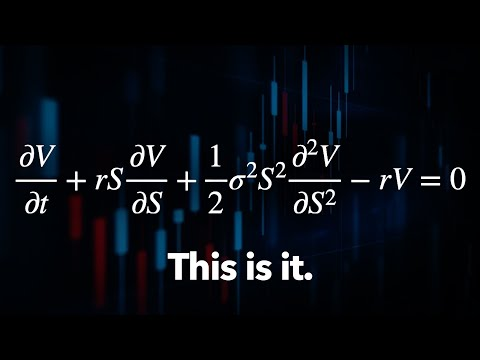

In [2]:
#@title Black-Scholes-Merton Equation
#@markdown  Motivation Video
YouTubeVideo("A5w-dEgIU1M", width=640, height=360)

* The implementation is the straightforward modification of
  Antoni Smolski code.

* I highly recommend reading his Blog!  
  https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  

* Another useful source:  
https://diter.medium.com/option-pricing-using-the-black-scholes-model-without-the-formula-e09235f75fb7

In [3]:
# sigma = the volatility of the stock (standard deviation)
#       = the degree of variation of a trading price series over time
# r = risk-free interest rate
# K = Strike price
# Ns = Number of asset price steps
# Nt = Number of time steps (Nt=0 means choose optimal number)

def Solve(sigma, r, K, T, Ns, Nt=0):
    Price = np.zeros(Ns + 1)            # Ns = Number of Asset steps array
    S = 3*K                             # Max asset price
    ds = S/Ns                           # asset price step
    if Nt==0:                           # Automatic optimal selection of time step
        dt = 0.9 / (sigma**2 * Ns**2)   # Stable optimal value of dt
        Nt = int(T/dt) + 1              # Number of time steps
    dt = T / Nt                         # Ensure that T is an integer number of time steps away
    V = np.zeros((Ns+1, Nt+1))          # Option Value Array (V FDM grid)

    for i in range(Ns+1):
        Price[i] = i*ds
        V[i,0] = max(Price[i] - K, 0)   # Initial condition at time t=0

    for k in range(1, Nt+1):  # Time loop
        # And now ta dam ... Nobel prize winning diff equation ;)
        for i in range(1, Ns):  # Asset loop
            delta = (V[i+1,k-1] - V[i-1,k-1]) / (2*ds)                 # Vs[i,k] as central difference
            gamma = (V[i+1,k-1] - 2*V[i,k-1] + V[i-1,k-1]) / (ds**2)   # Vss[i,k] as central difference
            theta = -0.5 * sigma**2 * Price[i]**2 * gamma - r*Price[i]*delta + r*V[i,k-1]
            V[i, k] = V[i, k - 1] - dt * theta

        V[0,k] = 0                     # Boundary condition at s=0
        V[Ns,k] = S - K*exp(-r*k*dt)   # Boundary condition at s=S (Smax)

    asset_steps = ds * np.arange(0, Ns + 1)   # Asset price steps from 0 to S (i*ds, i=0,1,..,Ns)
    time_steps = dt * np.arange(0, Nt + 1)    # Time steps from 0 to T (k*dt, k=0,1,..,Nt)
    rounded_asset_steps = np.round(asset_steps, decimals=3)
    rounded_time_steps = np.round(time_steps, decimals=4)
    #data = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)
    data = pd.DataFrame(np.transpose(V), index=rounded_time_steps, columns=rounded_asset_steps).round(3)
    data.attrs = dict(S=S, T=T, K=K, ds=ds, dt=dt, r=r, sigma=sigma, Ns=Ns, Nt=Nt)

    return data  # Output array as pandas data frame object





# A Simple Example
* In the following example we solve the BSM equation for a stock option
  with the following parameters.

In [4]:
K = 50            # Option strike price
S = 3*K           # Maximum asset price
T = 3             # Maximum time (in year units)
Ns = 40           # number of asset price steps
Nt = 0            # Let Solve choose an optimal number of time steps
sigma = 0.4       # Asset price sensitivity (aka volatility)
r = 0.05          # Interest rate

data = Solve(sigma, r, K, T, Ns, Nt)

* **data** is a [Pandas](https://pandas.pydata.org/)
  [DataFrame object](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
  which holds the FDM grid solution in a tabular form.
  This is a very useful info container which is easy to
  query.

* Here are the the first 5 rows of this table followed
  by the last 5 rows.
  
* The columns are asset price steps,
  and the lines are time steps.

In [5]:
data

,0.00,3.75,7.50,11.25,15.00,18.75,22.50,26.25,30.00,33.75,...,116.25,120.00,123.75,127.50,131.25,135.00,138.75,142.50,146.25,150.00
0.0000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.250,70.000,73.750,77.500,81.250,85.000,88.750,92.500,96.250,100.000
0.0035,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.259,70.009,73.759,77.509,81.259,85.009,88.759,92.509,96.259,100.009
0.0070,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.268,70.018,73.768,77.518,81.268,85.018,88.768,92.518,96.268,100.018
0.0105,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.276,70.026,73.776,77.526,81.276,85.026,88.776,92.526,96.276,100.026
0.0141,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.285,70.035,73.785,77.535,81.285,85.035,88.785,92.535,96.285,100.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.9859,0.0,0.001,0.025,0.147,0.465,1.050,1.933,3.119,4.592,6.333,...,74.485,78.063,81.651,85.247,88.850,92.459,96.072,99.690,103.311,106.934
2.9895,0.0,0.001,0.025,0.147,0.467,1.053,1.937,3.124,4.599,6.340,...,74.495,78.072,81.660,85.256,88.858,92.467,96.081,99.698,103.319,106.942
2.9930,0.0,0.001,0.025,0.148,0.468,1.055,1.941,3.129,4.605,6.347,...,74.504,78.082,81.669,85.265,88.867,92.475,96.089,99.706,103.326,106.949
2.9965,0.0,0.001,0.025,0.149,0.470,1.058,1.945,3.134,4.611,6.355,...,74.513,78.091,81.678,85.273,88.876,92.484,96.097,99.714,103.334,106.957


* On the right side of this table you will find three
  buttons for interacting with it just as if it was
  an Excel table.
  * The first button displays a full interactive table.
  * The second buttons dispaly several charts, and
    can create code for generating them
  * The third button is experimental AI code generator for
     extracting information from this table.

* To learn more on how you can interact with the **data** object
  read the
  [Pandas package reference guide](https://pandas.pydata.org/docs/user_guide/index.html)

* For example, to print the table index, use the command:

In [6]:
data.index

Index([   0.0, 0.0035,  0.007, 0.0105, 0.0141, 0.0176, 0.0211, 0.0246, 0.0281,
       0.0316,
       ...
       2.9684, 2.9719, 2.9754, 2.9789, 2.9824, 2.9859, 2.9895,  2.993, 2.9965,
          3.0],
      dtype='float64', length=855)

* To see the table columns (asset price steps):

In [7]:
data.columns

Index([   0.0,   3.75,    7.5,  11.25,   15.0,  18.75,   22.5,  26.25,   30.0,
        33.75,   37.5,  41.25,   45.0,  48.75,   52.5,  56.25,   60.0,  63.75,
         67.5,  71.25,   75.0,  78.75,   82.5,  86.25,   90.0,  93.75,   97.5,
       101.25,  105.0, 108.75,  112.5, 116.25,  120.0, 123.75,  127.5, 131.25,
        135.0, 138.75,  142.5, 146.25,  150.0],
      dtype='float64')

* A Pandas DataFrame can be also exporetd into a Microsoft Excel sheet easily!
* If you are a Microsoft Excel user, you may want to convert
  it to an Excel sheet, and then interact with it using
  Microsoft office analysis tools.

In [8]:
data.to_excel("data.xlsx")

* The resulting Excel file can be viewed
  [from this link](https://samyzaf.com/fdm/data.xlsx)

* But you can download this Excel sheet from here to your
  local disk by the following command.

In [ ]:
file_download("data.xlsx")

# BSM Heatmap
* The method **bsm_heatmap** can be used for drawing
  a heatmap of the tabular **data**.

* This method is part of our
  [**fdmtools package**](https://samyzaf.com/fdmtools-3.zip)
  and can be viewed by downloading this package.

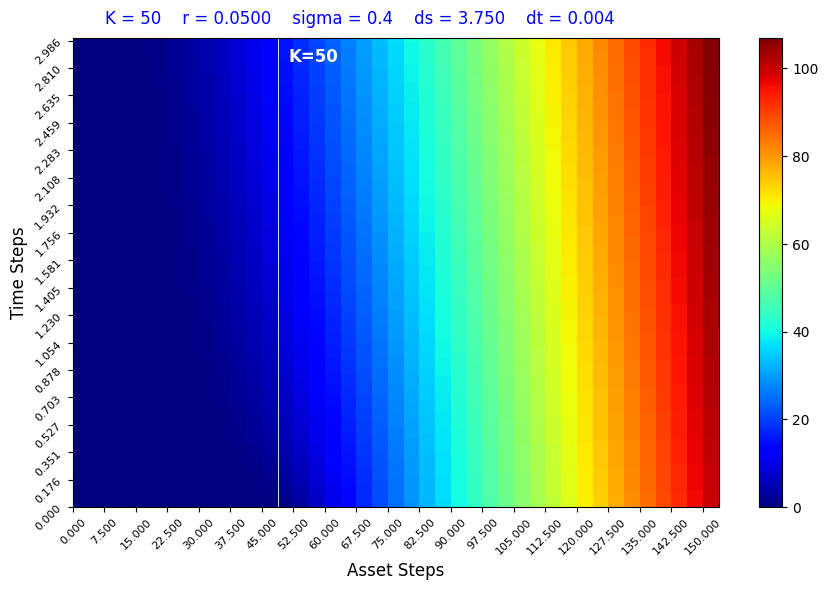

In [9]:
bsm_heatmap(data)


# BSM 3D surface representation
* There are more visualization aids available in Python's
  matplotlib package.

* Here is a 3D surface which represents **V**.

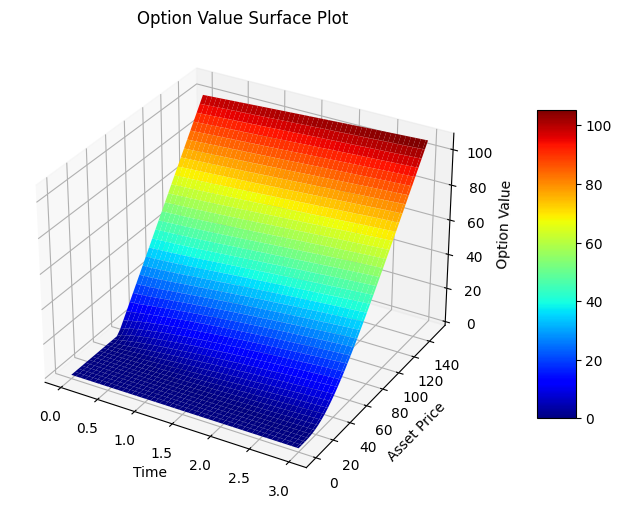

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
Y,X = np.meshgrid(data.columns, data.index)
Z = data.values
surf = ax.plot_surface(X, Y, Z, cmap="jet")
ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')
fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
plt.show()

# Extracting local and precision information
* The **data** object is quite large: 855 rows × 41 columns.
  That is 35055 entries!

* The heatmap and 3D surface plots are great **infographics**
  tools, but are not adequate for obtaining precise values
  for specific needs.

* In most cases we would like to inspect a small
  subset of information
  around specific values such as our strike price **K** and
  maturation time **t**.

* For example, if our strike price is **K=50** and maturation
  time is **t=2** (2 years), here is a small code snippet
  for extracting a small table around these values:

In [11]:
s = 50  # Strike price
t = 2   # Maturation time (2 years)
ds = data.attrs['ds']
dt = data.attrs['dt']
i = int(s/ds)
k = int(t/dt)
print(f"Extracting a small sub-table (10x10) around price s={s} and time t={t}")
data.iloc[k-5:k+5, i-5:i+5]

Extracting a small sub-table (10x10) around price s=50 and time t=2


,30.00,33.75,37.50,41.25,45.00,48.75,52.50,56.25,60.00,63.75
1.9813,2.744,4.117,5.776,7.700,9.865,12.244,14.810,17.539,20.411,23.404
1.9848,2.751,4.125,5.785,7.711,9.877,12.256,14.822,17.552,20.424,23.418
1.9883,2.758,4.133,5.795,7.722,9.889,12.268,14.835,17.566,20.438,23.431
1.9918,2.764,4.141,5.805,7.733,9.900,12.281,14.848,17.579,20.451,23.445
1.9953,2.771,4.149,5.814,7.743,9.912,12.293,14.861,17.592,20.464,23.458
1.9988,2.778,4.158,5.824,7.754,9.924,12.305,14.874,17.605,20.478,23.472
2.0023,2.784,4.166,5.833,7.765,9.935,12.318,14.887,17.619,20.491,23.485
2.0059,2.791,4.174,5.843,7.776,9.947,12.330,14.900,17.632,20.505,23.499
2.0094,2.798,4.182,5.852,7.786,9.959,12.343,14.913,17.645,20.518,23.512
2.0129,2.804,4.190,5.862,7.797,9.970,12.355,14.925,17.658,20.531,23.525


* The **data** object has a special attributes
  dictionary **data.attrs**
  which holds all the parameters: **S, K, T, ds, st, ...**

* Like in Microsoft Excel, to access **data** we need integer
  indices **i**, **k**.
  Beware that **k** is a row index, and **i** is a column index!

* Therefore we had to convert the price value **s=50**
  to its corresponding column index **i=s/ds**,
  and the time value **t=2.0** to its corresponding
  row index **k=t/dt**.

* To access 10 rows around **i** we use a range expression
  **i-5:i+5**.

* But the first thing we should have noticed is that
  our desired price **s=50** and time **t=2**
  are **not** in this table!

* This is a typical issue with discrete models, which is
  confronted by a special interpolation procedure for
  computing the in between values.

* Our **fdmtools** package includes an **interpolate** method
  for handling this issue

In [12]:
s = 50.0
t = 2.0
v = interpolate(data, s, t)
print(v)

13.16566666666667


* So the value of a **CALL option** with price **s=50** for **t=2** years with
  a strike price **s=50** is **v=13.166**

* We may want to compare it against values with different strike
  prices 45-55.

* We can also reconsider our maturation time to be **t=1.0**.
  We have a method for generating a local table around
  **s=50, t=1.0**.

In [14]:
local_table(data, s=50, t=1.0)

,30.00,33.75,37.50,41.25,45.00,48.75,52.50,56.25,60.00,63.75
0.9801,0.889,1.666,2.777,4.236,6.034,8.146,10.539,13.177,16.022,19.041
0.9836,0.895,1.675,2.789,4.250,6.049,8.163,10.557,13.195,16.040,19.059
0.9871,0.901,1.684,2.800,4.264,6.065,8.180,10.575,13.213,16.058,19.076
0.9906,0.907,1.692,2.812,4.278,6.081,8.197,10.592,13.231,16.076,19.094
0.9941,0.913,1.701,2.823,4.292,6.097,8.214,10.610,13.249,16.094,19.111
0.9977,0.919,1.710,2.835,4.305,6.112,8.231,10.628,13.267,16.111,19.129
1.0012,0.925,1.719,2.846,4.319,6.128,8.248,10.645,13.285,16.129,19.146
1.0047,0.931,1.728,2.858,4.333,6.144,8.265,10.663,13.302,16.147,19.163
1.0082,0.937,1.736,2.869,4.347,6.159,8.282,10.681,13.320,16.165,19.181
1.0117,0.943,1.745,2.881,4.361,6.175,8.298,10.698,13.338,16.182,19.198
